In [1]:
import os
import sys
code_dir = os.path.split(os.getcwd())[0]
if code_dir not in sys.path:
    sys.path.append(code_dir)

In [2]:
import numpy as np
import pickle

# my code
from contrastive_divergence_optimiser import CDOptimiser
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine
from utils import plot_log_likelihood_training_curves, takeClosest, create_J_plot

from collections import OrderedDict
from copy import deepcopy
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from pandas import DataFrame
from pomegranate import BayesianNetwork

%matplotlib inline
rc('lines', linewidth=1.5)
rc('font', size=18)
rc('legend', fontsize=16)
rc('text', usetex=True)

# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
exp_name = 'maxiter_comparison-20by15'  # CHANGE ME

exp_res_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/experimental-results/'
save_res_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/experiments/'
exp_dir = os.path.join(exp_res_dir, exp_name)
save_dir = os.path.join(save_res_dir, exp_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## plot J & LL

In [4]:
def sanity_check_stats(J1s, Js_for_lnce_thetas, file):
    stats ='file: {0}. Percentage of iters for which J1 increases: {1:.4g}%\n          Percentage of iters for which J increases: {2:.4g}%\n          Percentage of iters for which J1 is less than J: {3:.4g}%\n'.format(file, 
    100* np.sum(np.array([J1a < J1b for J1a, J1b in zip(J1s[:-1], J1s[1:])])) / (len(J1s)-1),
    100*np.sum(np.array([Ja < Jb for Ja, Jb in zip(Js_for_lnce_thetas[:-1], Js_for_lnce_thetas[1:])])) / (len(Js_for_lnce_thetas)-1),
    100*np.mean(J1s < Js_for_lnce_thetas))
    
    return stats

In [5]:
def annotate(ax, annotation, xy):
    ax.annotate(annotation, xy=xy, xycoords='data', xytext=(15, 30), textcoords="offset points", 
        arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', 
        verticalalignment='bottom', fontsize=16)

In [6]:
def plot_and_annotate(ax, times, vals, annotation, annotate_val):
    ax.semilogx(times, vals)
    ind = takeClosest(vals, annotate_val)
    annotate(ax, annotation, (times[ind], vals[ind]))
    ax.annotate(r"{}".format(round(vals[-1], 4)), xy=(times[-1], vals[-1]), fontsize=12)

file: 1. Percentage of iters for which J1 increases: 68.63%
          Percentage of iters for which J increases: 63.47%
          Percentage of iters for which J1 is less than J: 15.69%

file: 5. Percentage of iters for which J1 increases: 85.84%
          Percentage of iters for which J increases: 67.49%
          Percentage of iters for which J1 is less than J: 5.356%

file: 2. Percentage of iters for which J1 increases: 75.62%
          Percentage of iters for which J increases: 60.17%
          Percentage of iters for which J1 is less than J: 11.1%

file: 10. Percentage of iters for which J1 increases: 91.73%
          Percentage of iters for which J increases: 64.25%
          Percentage of iters for which J1 is less than J: 3.749%

file: 20. Percentage of iters for which J1 increases: 95.48%
          Percentage of iters for which J increases: 62.39%
          Percentage of iters for which J1 is less than J: 1.963%

file: 50. Percentage of iters for which J1 increases: 98.08%
   

/afs/inf.ed.ac.uk/user/s17/s1771906/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/afs/inf.ed.ac.uk/user/s17/s1771906/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


file: cd1_large_epochs. Percentage of iters for which J1 increases: nan%
          Percentage of iters for which J increases: nan%
          Percentage of iters for which J1 is less than J: 0%



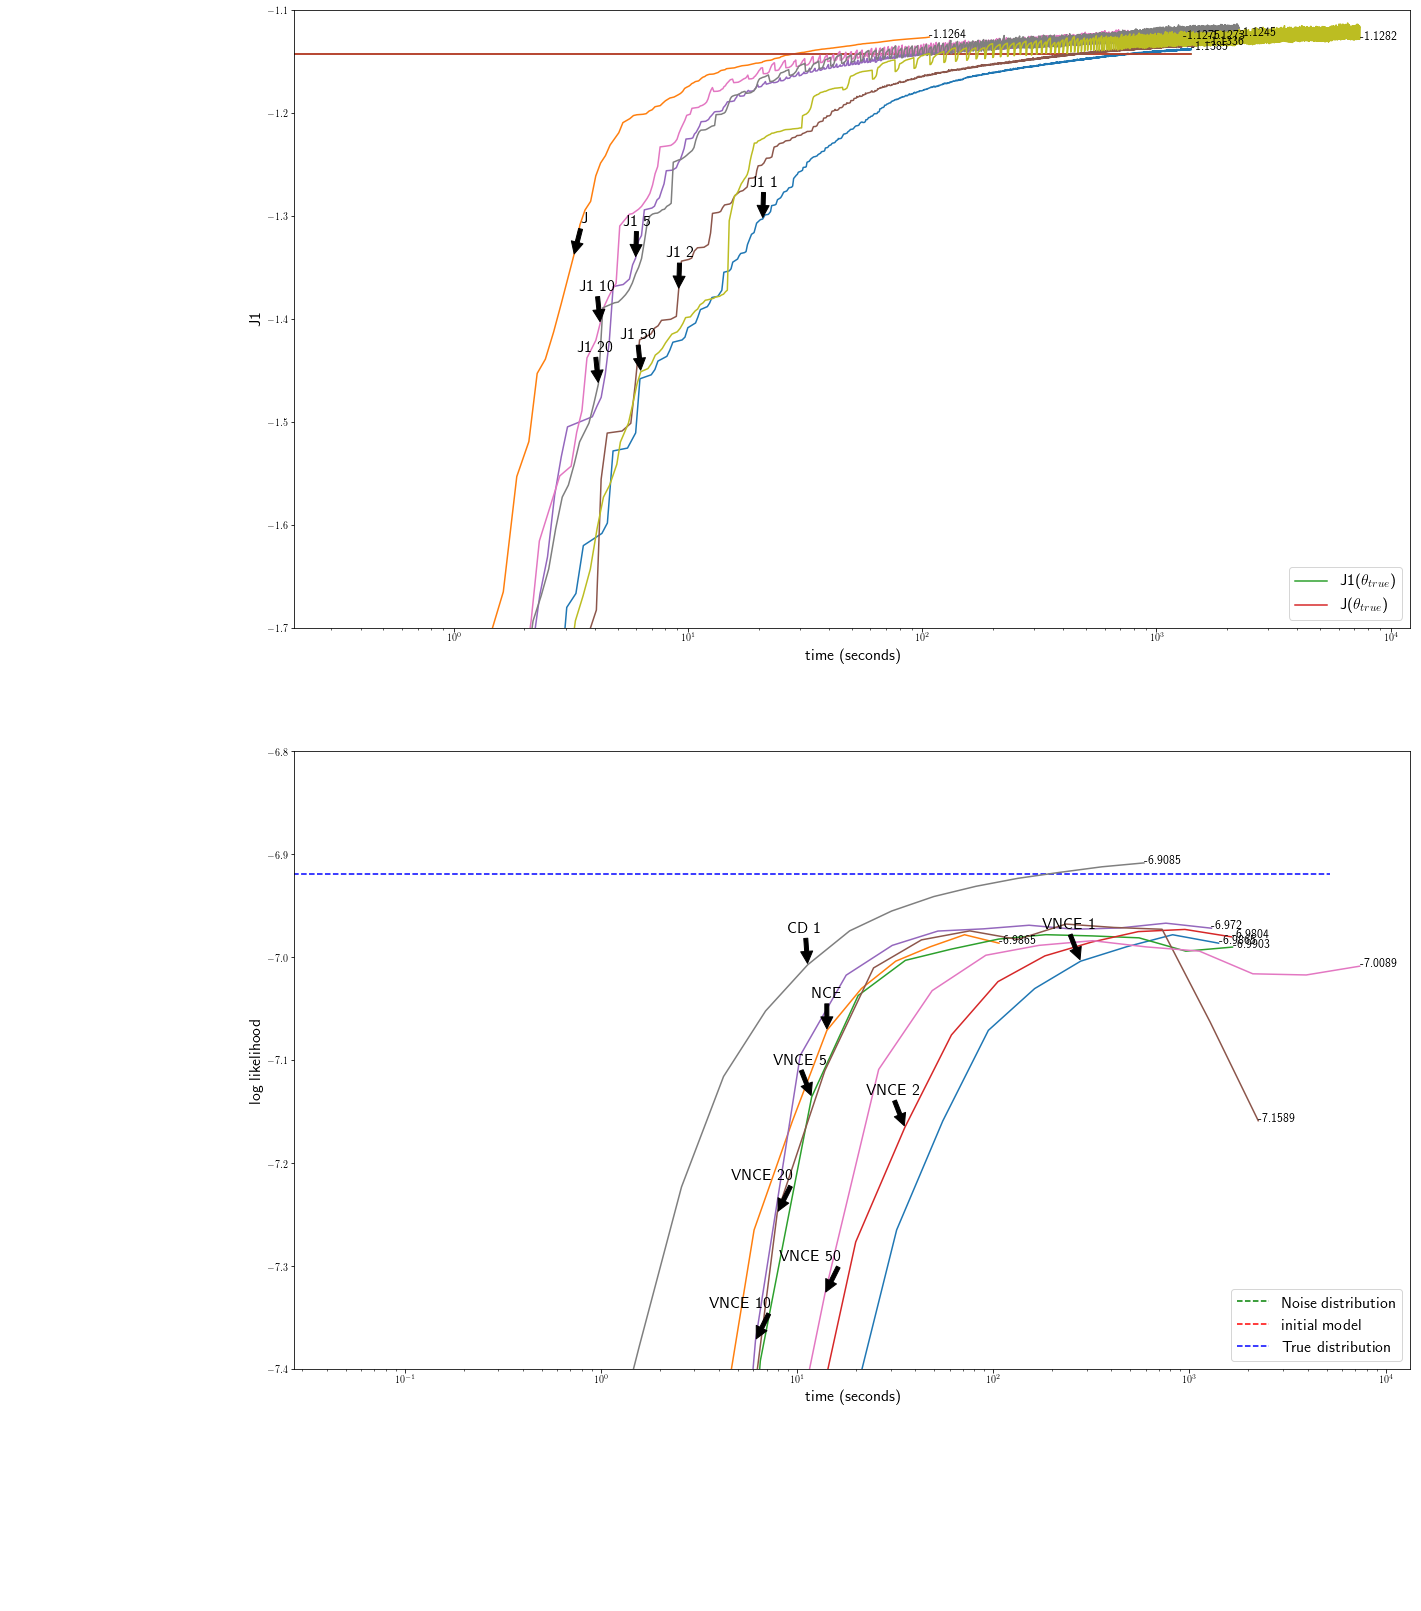

In [20]:
# CHANGE ME
arrow_y_val = -1.3
arrow_y_val_2 = -1.4
arrow_y_val_3 = -7.0 # log-like plot vnce
arrow_y_val_4 = -7.0 # log-like plot cd

fig, axs = plt.subplots(2, 1, figsize=(20, 25))
axs = axs.ravel()
#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    if file in ['1-nz=5', '10-nz=5']:
        continue
    
    ######## LOAD EVERYTHING FROM FILE #########
    config = pickle.load(open(os.path.join(exp, 'config.p'), 'rb'))
    
    optimiser = pickle.load(open(os.path.join(exp, 'lnce_optimiser.p'), 'rb'))
    cd_optimiser = pickle.load(open(os.path.join(exp, 'cd_optimiser.p'), 'rb'))
    nce_optimiser = pickle.load(open(os.path.join(exp, 'nce_optimiser.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_truth = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    loaded_init = np.load(os.path.join(exp, 'init_theta_and_likelihood.npz'))
    loaded_lnce = np.load(os.path.join(exp, 'lnce_results.npz'))
    loaded_cd = np.load(os.path.join(exp, 'cd_results.npz'))
    loaded_nce = np.load(os.path.join(exp, 'nce_results.npz'))
    loaded_true = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    
    X = loaded_data['X']
    Y = loaded_data['Y']
    
    true_theta = loaded_truth['true_theta']
    true_log_like = loaded_truth['ll']
    
    theta0 = loaded_init['theta0']
    init_log_like = loaded_init['ll']
    
    J1s = loaded_lnce['J1s']
    lnce_thetas = loaded_lnce['params']
    lnce_times = loaded_lnce['times']
    lnce_reduced_times = loaded_lnce['reduced_times']
    av_log_like_lnce = loaded_lnce['ll']
    
    cd_times = loaded_cd['times']
    cd_reduced_times = loaded_cd['reduced_times']
    av_log_like_cd = loaded_cd['ll']
    
    Js = loaded_nce['Js']
    Js_for_lnce_thetas = loaded_nce['Js_for_lnce_thetas']
    nce_times = loaded_nce['times']
    nce_reduced_times = loaded_nce['reduced_times']
    av_log_like_nce = loaded_nce['ll']
    
    optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
    optimal_J = nce_optimiser.evaluate_J_at_param(true_theta.reshape(-1), X)
    
    noise = MultivariateBernoulliNoise(np.mean(X, axis=0))
    noise_log_like = np.mean(np.log(noise(X)))
    
    if J1s.ndim == 2:
        J1s = np.sum(J1s, axis=1)
        Js_for_lnce_thetas = np.sum(Js_for_lnce_thetas, axis=1)
    
    ####### ACTUAL PLOTTING ###########
    
    # NCE OBJECTIVE PLOT
    ax = axs[0]
    plot_and_annotate(ax, lnce_times, J1s, r"J1 {}".format(file), arrow_y_val)
    arrow_y_val -= 0.03
    #plot_and_annotate(ax, lnce_times, Js_for_lnce_thetas, r"J {}".format(file), arrow_y_val_2)
    ax.set_xlabel('time (seconds)', fontsize=16)
    ax.set_ylabel('J1', fontsize=16)
    
    # LOG-LIKELIHOOD PLOT
    ax = axs[1]
    if file == 'cd1_large_epochs':
        plot_and_annotate(ax, cd_reduced_times, av_log_like_cd, "CD {}".format(config['cd_num_steps']), arrow_y_val_4)
        arrow_y_val_4 -= 0.05
    else:
        plot_and_annotate(ax, lnce_reduced_times, av_log_like_lnce, "VNCE {}".format(file), arrow_y_val_3)
        arrow_y_val_3 -= 0.05
    
    ax.set_xlabel('time (seconds)', fontsize=16)
    ax.set_ylabel('log likelihood', fontsize=16)
    
    
    if i == 0:
        ax = axs[0]
        plot_and_annotate(ax, nce_times, Js, "J", arrow_y_val)
        ax.plot((lnce_times[0], lnce_times[-1]), (optimal_J1, optimal_J1), label=r'J1($\theta_{true}$)')
        ax.plot((lnce_times[0], lnce_times[-1]), (optimal_J, optimal_J), label=r'J($\theta_{true}$)')
        
        ax = axs[1]  
        plot_and_annotate(ax, nce_reduced_times, av_log_like_nce, "NCE", arrow_y_val_3)  
        ax.plot((0, plt.get(ax, 'xlim')[1]), (noise_log_like, noise_log_like),'g--', label='Noise distribution')
        ax.plot((0, plt.get(ax, 'xlim')[1]), (init_log_like, init_log_like),'r--', label='initial model')
        ax.plot((0, plt.get(ax, 'xlim')[1]), (true_log_like, true_log_like),'b--', label='True distribution')
    
    stats = sanity_check_stats(J1s, Js_for_lnce_thetas, file)     
    print(stats)
    if i == 0:
        with open(os.path.join(save_dir, 'vnce_sanity_check.txt'), 'w') as f:
            f.write(stats)
    else:
        with open(os.path.join(save_dir, 'vnce_sanity_check.txt'), 'a') as f:
            f.write(stats)
            
    with open(os.path.join(save_dir, "config-{}.txt".format(file)), 'w') as f:
        for key, value in config.items():
            f.write("{}: {}\n".format(key, value))
            

#axs[0].set_xlim(1e0, 2e3)
axs[0].set_ylim((-1.7, -1.1))

#axs[1].set_xlim((1e-1, 2e3))
axs[1].set_ylim((-7.4, -6.8))

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')

fig.savefig(os.path.join(save_dir, 'partial-mstep-comparison_just_cd1.pdf'))

## plot two terms of J1/J separately

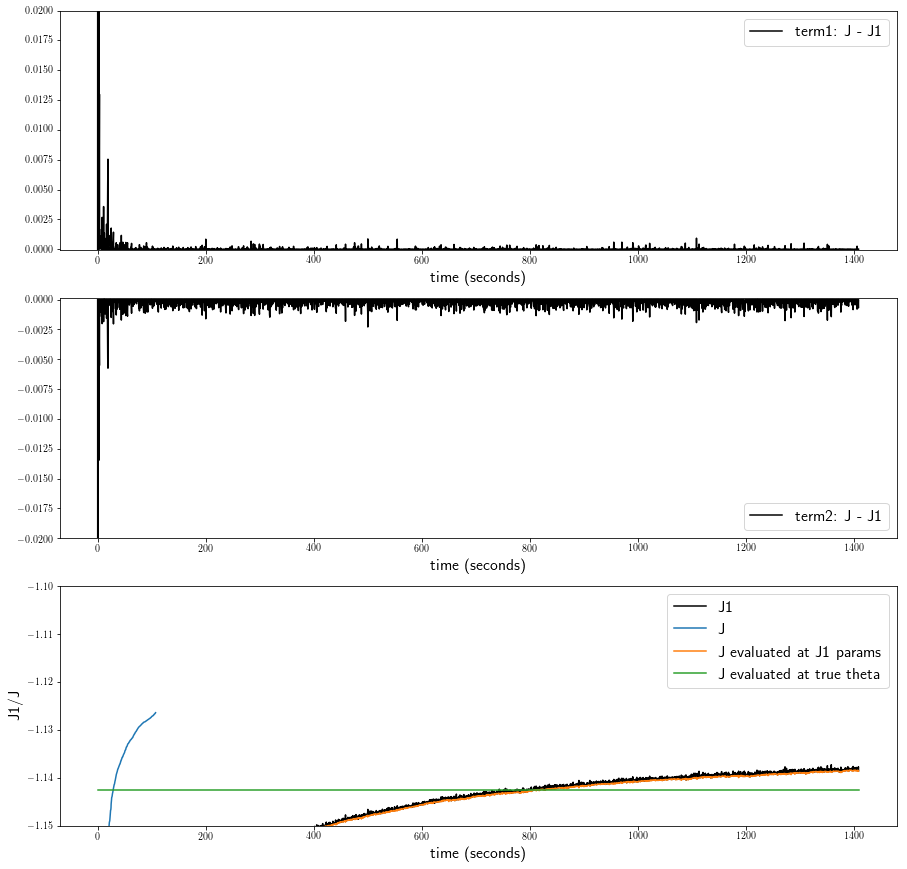

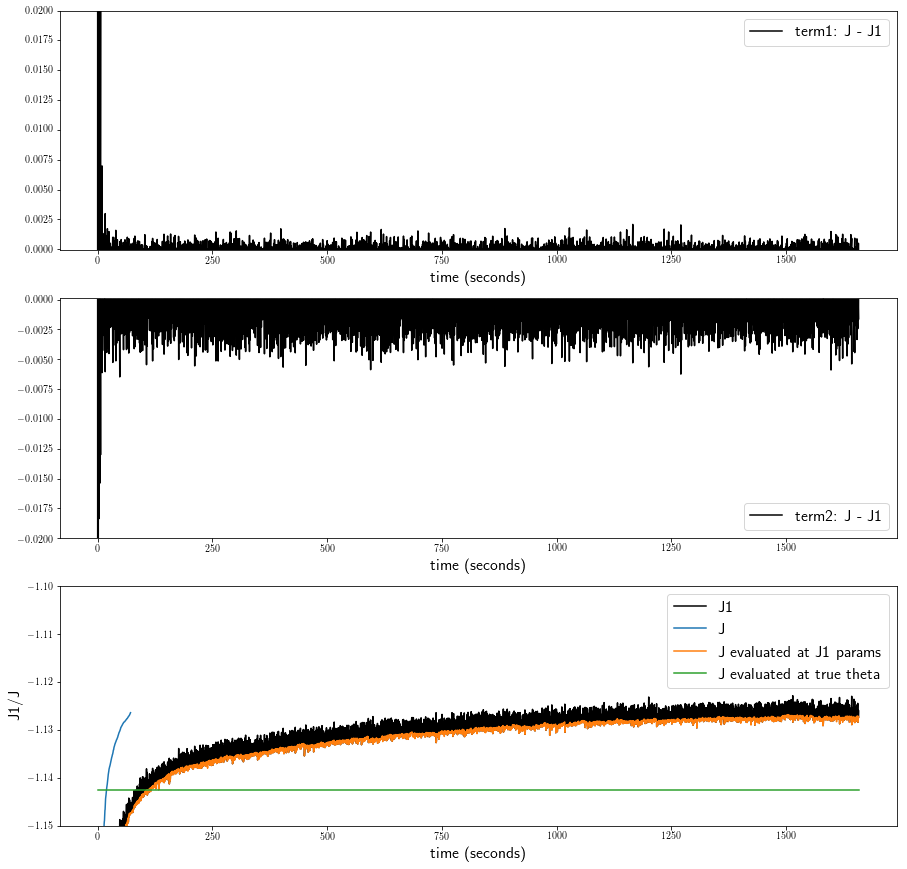

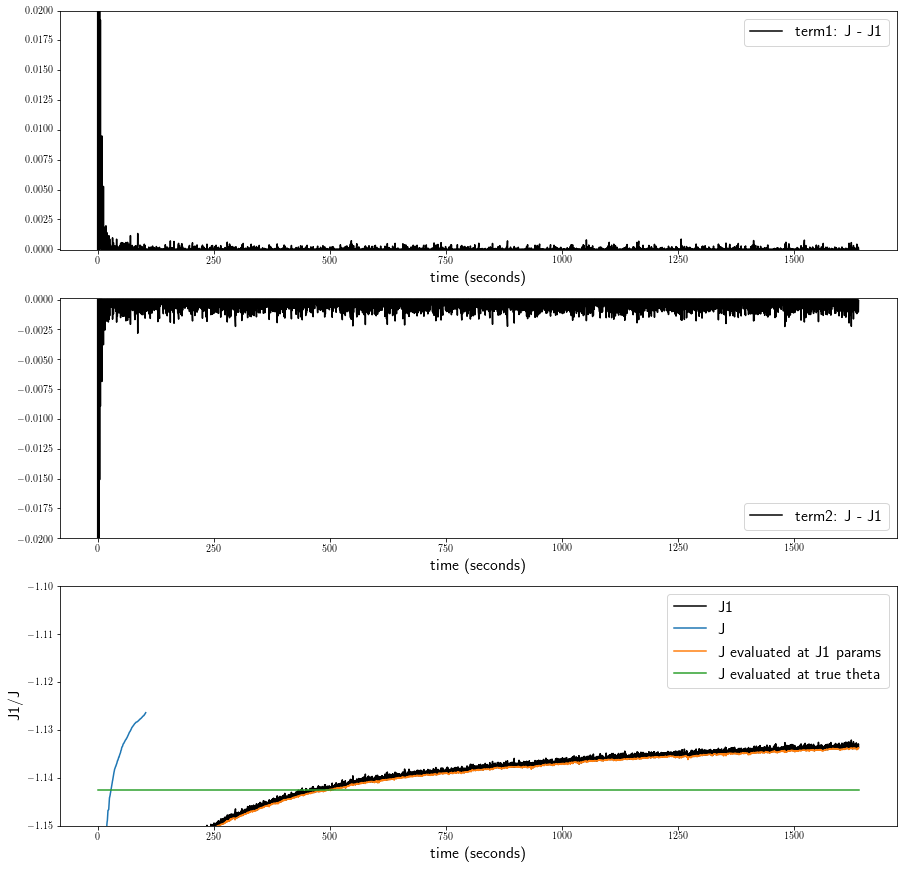

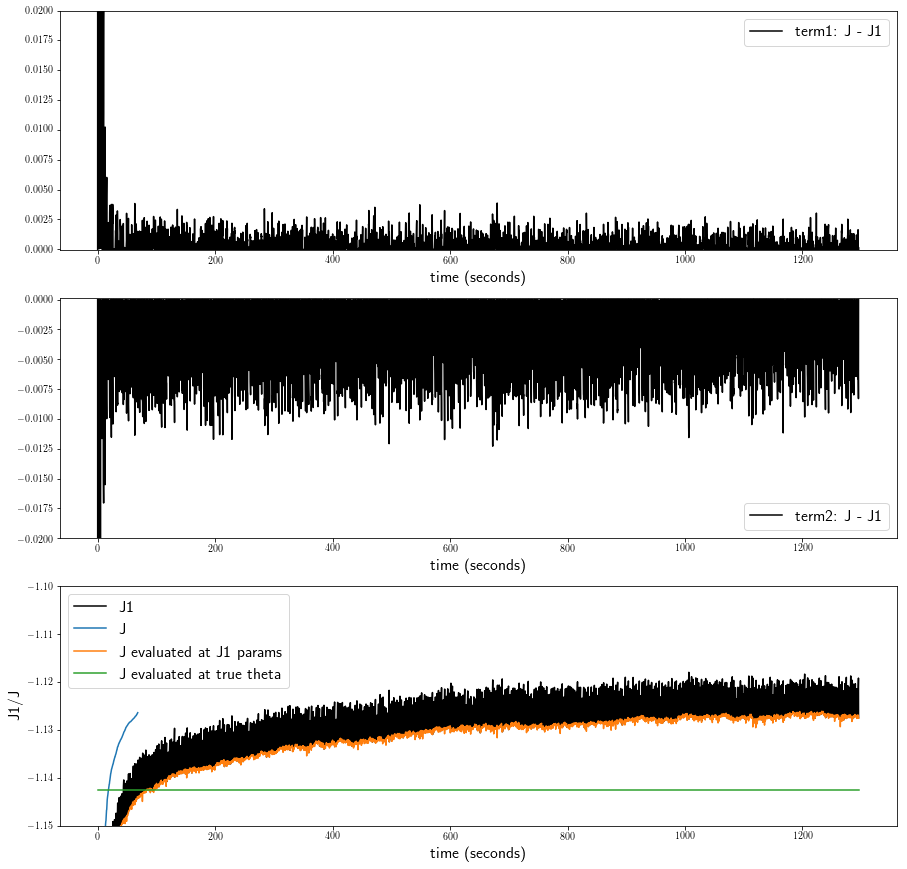

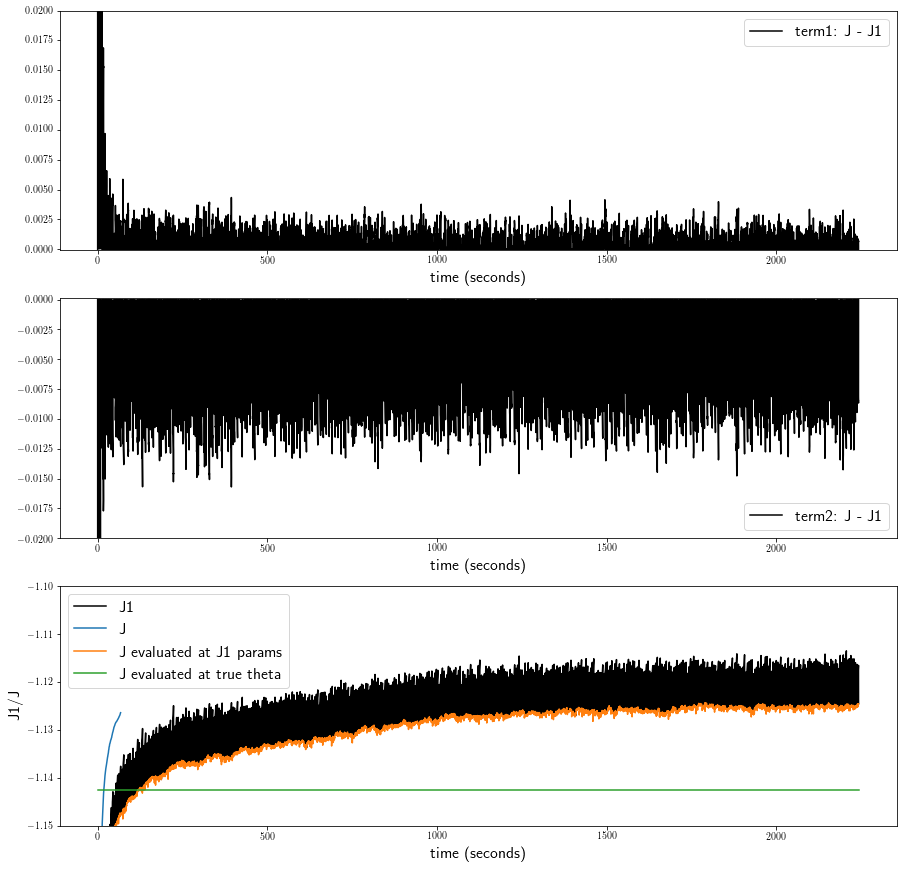

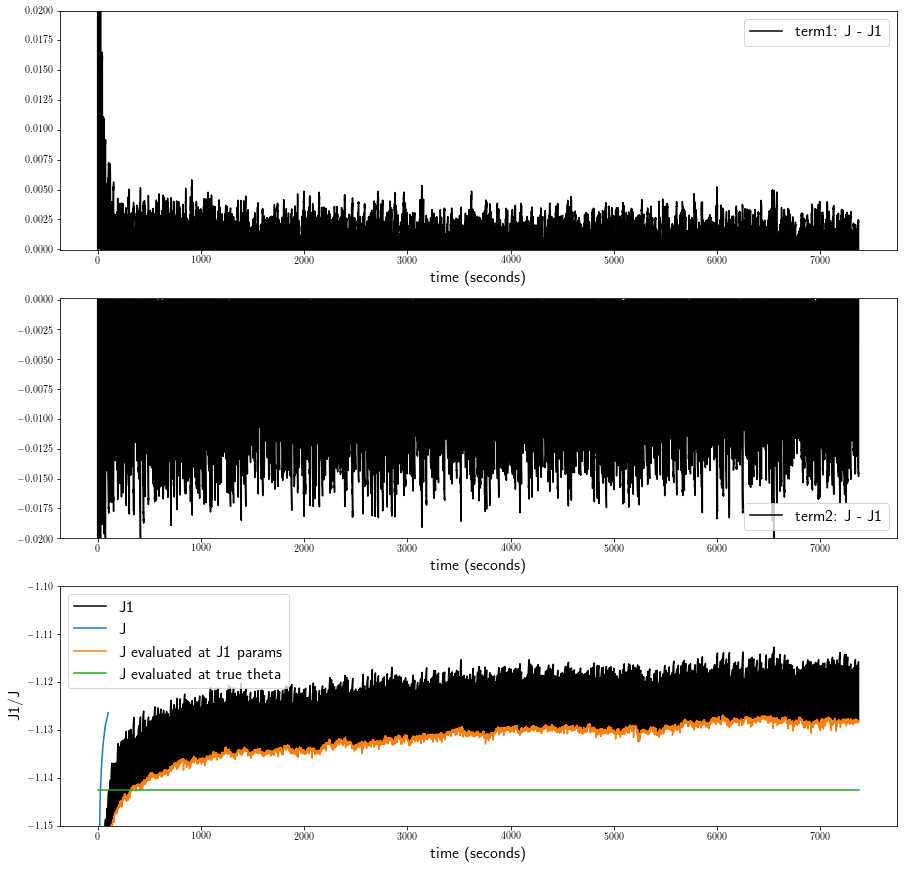

In [15]:
#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    
    ######## LOAD EVERYTHING FROM FILE #########
    if file in ['1-nz=5', '10-nz=5', 'cd1_large_epochs']:
        continue
        
    optimiser = pickle.load(open(os.path.join(exp, 'lnce_optimiser.p'), 'rb'))
    nce_optimiser = pickle.load(open(os.path.join(exp, 'nce_optimiser.p'), 'rb'))
    
    config = pickle.load(open(os.path.join(exp, 'config.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_truth = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    loaded_init = np.load(os.path.join(exp, 'init_theta_and_likelihood.npz'))
    loaded_lnce = np.load(os.path.join(exp, 'lnce_results.npz'))
    loaded_nce = np.load(os.path.join(exp, 'nce_results.npz'))
    loaded_true = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    
    X = loaded_data['X']
    Y = loaded_data['Y']
    
    true_theta = loaded_truth['true_theta']
    true_log_like = loaded_truth['ll']
    
    theta0 = loaded_init['theta0']
    init_log_like = loaded_init['ll']
    
    J1s = loaded_lnce['J1s']
    J1s_1 = J1s[:, 0]
    J1s_2 = J1s[:, 1]
    lnce_thetas = loaded_lnce['params']
    lnce_times = loaded_lnce['times']
    lnce_reduced_times = loaded_lnce['reduced_times']
    av_log_like_lnce = loaded_lnce['ll']
    
    Js = loaded_nce['Js']
    Js_for_lnce_thetas = loaded_nce['Js_for_lnce_thetas']
    nce_times = loaded_nce['times']
    nce_reduced_times = loaded_nce['reduced_times']
    av_log_like_nce = loaded_nce['ll']
    
    optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
    optimal_J = nce_optimiser.evaluate_J_at_param(true_theta.reshape(-1), X)
    
    noise = MultivariateBernoulliNoise(np.mean(X, axis=0))
    noise_log_like = np.mean(np.log(noise(X)))
    
    ####### ACTUAL PLOTTING ###########
    J_plot, _ = create_J_plot(X, nce_optimiser, optimiser, true_theta, True, Js_for_lnce_thetas=Js_for_lnce_thetas)
    axs = J_plot.axes
#     ind1 = int(len(J1s_1)/2)
#     ind2 = int(len(J1s_2)/3)
#     annotate(ax, r"term1 J1 {}".format(file), (lnce_times[ind1], J1s_1[ind1]))
#     annotate(ax, r"term2 J1 {}".format(file), (lnce_times[ind2], J1s_2[ind2]))
        
    #axs[0].set_xlim((0, 1e1))
    axs[0].set_ylim((-0.0001, 0.02))
    axs[1].set_ylim((-0.02, 0.0001))
#    axs[2].set_xlim((-1e-1, 500))
    axs[2].set_ylim((-1.15, -1.1))
    J_plot.set_size_inches(15, 15)

    J_plot.savefig(os.path.join(save_dir, 'two-terms-of-J1-{}.pdf'.format(file)))

## Plot J (not LL)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    
    optimiser = pickle.load(open(os.path.join(exp, 'lnce_optimiser.p'), 'rb'))
    nce_optimiser = pickle.load(open(os.path.join(exp, 'nce_optimiser.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_lnce = np.load(os.path.join(exp, 'lnce_results.npz'))
    loaded_cd = np.load(os.path.join(exp, 'cd_results.npz'))
    loaded_nce = np.load(os.path.join(exp, 'nce_results.npz'))
    loaded_true = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    
    X = loaded_data['X']
    Y = loaded_data['Y']
    true_theta = loaded_true['true_theta']
    
    lnce_thetas = loaded_lnce['params']
    J1s = loaded_lnce['J1s']
    lnce_times = loaded_lnce['times']
    
    nce_thetas = loaded_nce['params']
    Js = loaded_nce['Js']
    Js_for_lnce_thetas = loaded_nce['Js_for_lnce_thetas']
    nce_times = loaded_nce['times']

    ax.plot(lnce_times, J1s, label='Latent NCE {}'.format(file))
    ax.annotate(r"J1 {}".format(file), xy=(lnce_times[-1], J1s[-1]), fontsize=14, weight='bold')
    
    ax.plot(lnce_times, Js_for_lnce_thetas, label='J evaluated at J1 params')
    ax.annotate(r"J {}".format(file), xy=(lnce_times[-1], Js_for_lnce_thetas[-1]), fontsize=14,weight='bold')

ax.plot(nce_times, Js, label='J')
ax.annotate(r"J".format(file), xy=(nce_times[-1], Js[-1]), fontsize=14, weight='bold')

optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
ax.plot((lnce_times[0], lnce_times[-1]), (optimal_J1, optimal_J1), label=r'J1($\theta_{true}$)')

optimal_J = nce_optimiser.evaluate_J_at_param(true_theta.reshape(-1), X)
ax.plot((lnce_times[0], lnce_times[-1]), (optimal_J, optimal_J), label=r'J($\theta_{true}$)')

ax.set_xlabel('time (seconds)', fontsize=16)
ax.set_ylabel('J1', fontsize=16)
ax.set_ylim((-1.175, -1.10))
#ax.set_xlim((0, 50))
ax.legend()
_ = ax.legend(loc='lower right')


#fig.savefig(os.path.join(save_dir, 'partial-mstep-comparison_Js.pdf'))